In [1]:
import os
os.chdir('/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/scripts')
plotsdir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/plots/" + x
GLORYS_dir = lambda x="": "/vortexfs1/home/anthony.meza/GLORYS_data" + x
GLORYS_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/GLORYS_processed/" + x
ERA5_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/ERA5_data/" + x

In [2]:
# from help_funcs import * 
# from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import importlib
import xarray as xr
import seaborn as sns
import pandas as pd
import cmocean.cm as cm
import netCDF4 as nc
import matplotlib.pyplot as plt
import gsw
import gc
from multiprocessing import Pool
import os 
import multiprocessing
from os.path import exists
sns.set_context("notebook")
import dask_labextension
from pathlib import Path
import numpy as np
import dask
# dask.config.set({"array.slicing.split_large_chunks": False})

In [3]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='100GB',
    walltime='02:00:00',
    queue='compute',
    interface='ib0')
print(cluster.job_script())
cluster.scale(jobs=8)
from dask.distributed import Client
client = Client(cluster)

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=94G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/bin/python -m distributed.cli.dask_worker tcp://172.16.3.106:38137 --nthreads 36 --memory-limit 93.13GiB --name dummy-name --nanny --death-timeout 60 --interface ib0



In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.106:38137,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Reading in the GLORYS and ERA5 data files. Files have been preprocessed and combined in order to take advantage of the **dask** feature of xarray. We also remove their seasonal cliamtologies

In [5]:
%%time 
def _preprocess(ds):
    return ds[["thetao", "zos"]].sel(latitude = slice(32, 34), longitude = slice(-120, -116), time = slice("1993", "2018"))

ds = xr.open_mfdataset(
        GLORYS_data_dir("GLORYS_NE_PAC.nc"),
        data_vars="minimal",
        coords="minimal",
        compat="override",
        preprocess=_preprocess,
        parallel=True,
        chunks={"time":320, "latitude":-1, "longitude":-1, "depth":1},
        engine="netcdf4")

CPU times: user 312 ms, sys: 26 ms, total: 338 ms
Wall time: 7.35 s


In [6]:
def _preprocess_ERA5(ds):
    return ds.sel(latitude = slice(34, 32)).sel(longitude = slice(-120, -116)).sel(time = slice("1993", "2018"))

era5_ds = xr.open_mfdataset(GLORYS_data_dir("ERA5_NE_PAC_daily.nc"), 
        data_vars="minimal", coords="minimal",
        compat="override", preprocess=_preprocess_ERA5,
        parallel=True, chunks={"longitude": -1, "latitude":-1, "time":320}, engine="netcdf4")


In [7]:
era5_ds = era5_ds.mean(dim = ["latitude", "longitude"]).compute()
ds = ds.mean(dim = ["latitude", "longitude"]).compute()

Text(0.5, 1.0, 'Coastal SST Climatologies near Southern California')

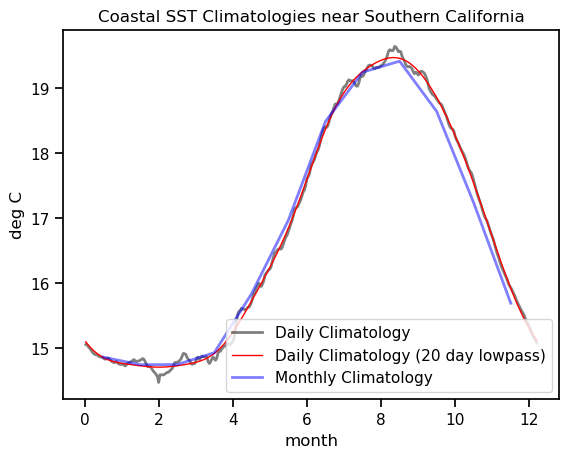

In [16]:
# daily_climatology = ds.groupby("time.dayofyear").mean("time")
daily_climatology = daily_climatology_leapyears(ds)

monthly_climatology = ds.groupby("time.month").mean("time")
smooth_daily = smooth_daily_climatology(ds, 0) 


dclim = daily_climatology.thetao.isel(depth = 0).values
xdclim = daily_climatology.doy.values * (1/30) 
mclim = monthly_climatology.thetao.isel(depth = 0).values
fig, ax = plt.subplots()
ax.plot(xdclim, dclim, label = "Daily Climatology", alpha = 0.5, c = "k", linewidth = 2)
ax.plot(xdclim, smooth_daily.thetao.isel(depth = 0).values, label = "Daily Climatology (20 day lowpass)", c = "red", linewidth = 1)
ax.plot(np.arange(1, 13) - 0.5 , mclim, label = "Monthly Climatology", alpha = 0.5, c = "blue", linewidth = 2)
ax.legend(); ax.set_ylabel("deg C")
ax.set_xlabel("month"); ax.set_title("Coastal SST Climatologies near Southern California")

Text(0.5, 1.0, 'Precipitation Climatologies near Los Angeles')

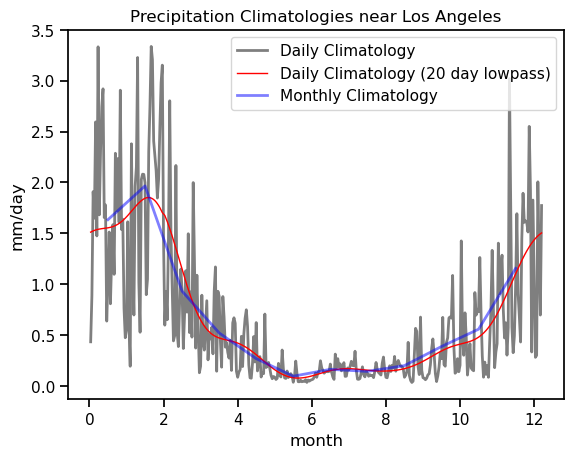

In [26]:
daily_climatology = era5_ds.groupby("time.dayofyear").mean("time")
monthly_climatology = era5_ds.groupby("time.month").mean("time")
smooth_daily = smooth_daily_climatology(era5_ds, 0) 

dclim = daily_climatology.tp.values
xdclim = daily_climatology.dayofyear.values * (1/30) 
xdclimx = smooth_daily.doy.values * (1/30) 

mclim = monthly_climatology.tp.values
xmclim = np.arange(1, 13) - 0.5

fig, ax = plt.subplots()
ax.plot(xdclim, dclim, label = "Daily Climatology", alpha = 0.5, c = "k", linewidth = 2)
ax.plot(xdclimx, smooth_daily.tp.values, label = "Daily Climatology (20 day lowpass)", c = "red", linewidth = 1)
ax.plot(xmclim , mclim, label = "Monthly Climatology", alpha = 0.5, c = "blue", linewidth = 2)
ax.legend(); ax.set_ylabel("mm/day")
ax.set_xlabel("month"); ax.set_title("Precipitation Climatologies near Los Angeles")

Text(0.5, 1.0, 'Coastal SSH Climatologies near Southern California')

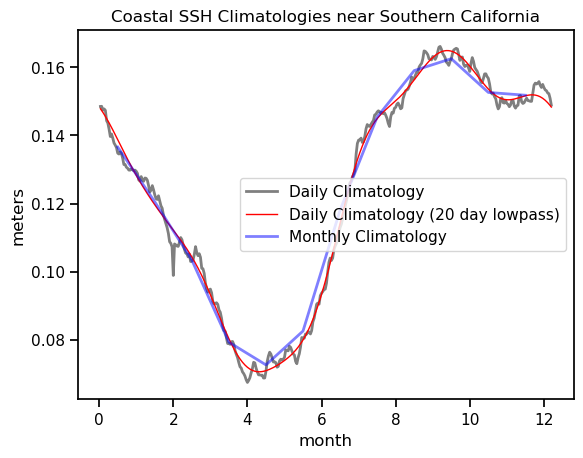

In [29]:
# daily_climatology = ds.groupby("time.dayofyear").mean("time")
daily_climatology = daily_climatology_leapyears(ds)

monthly_climatology = ds.groupby("time.month").mean("time")
smooth_daily = smooth_daily_climatology(ds, 0) 


dclim = daily_climatology.zos.values
xdclim = daily_climatology.doy.values * (1/30) 
mclim = monthly_climatology.zos.values
fig, ax = plt.subplots()
ax.plot(xdclim, dclim, label = "Daily Climatology", alpha = 0.5, c = "k", linewidth = 2)
ax.plot(xdclim, smooth_daily.zos.values, label = "Daily Climatology (20 day lowpass)", c = "red", linewidth = 1)
ax.plot(np.arange(1, 13) - 0.5 , mclim, label = "Monthly Climatology", alpha = 0.5, c = "blue", linewidth = 2)
ax.legend(); ax.set_ylabel("meters")
ax.set_xlabel("month"); ax.set_title("Coastal SSH Climatologies near Southern California")